In [34]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../ChordDetection")
import ChordDetection

In [35]:
DC = ChordDetection.DetectChords()

In [36]:
DC.build_cnn_extractor()
DC.build_crf()

In [37]:
DC.initialize_chord_axis()

In [38]:
song_path = './data/anunciacao.wav'

In [39]:
DC.wav_song = song_path[:-3]+'wav'
DC.song_name = song_path.split('/')[-1].replace('+', ' ')[:-4]

In [40]:
predictions_shape = DC.predict_seq()



Making predictions - this might take 1-3 minutes. Please wait...

1/1 [==============================] - 0s 54ms/step
Predictions are created.


In [41]:
print(f'Song ends on {predictions_shape[1]//10}th second. Keep this in mind when setting time interval to visualize!')

Song ends on 288th second. Keep this in mind when setting time interval to visualize!


In [42]:
plt.rcParams.update({'font.size': 20, 'xtick.major.pad': 15, 
                     'ytick.major.pad': 40, 'axes.titlepad': 15,
                     'xtick.bottom': False, 'ytick.left': False, 'figure.figsize': (70, 25)})

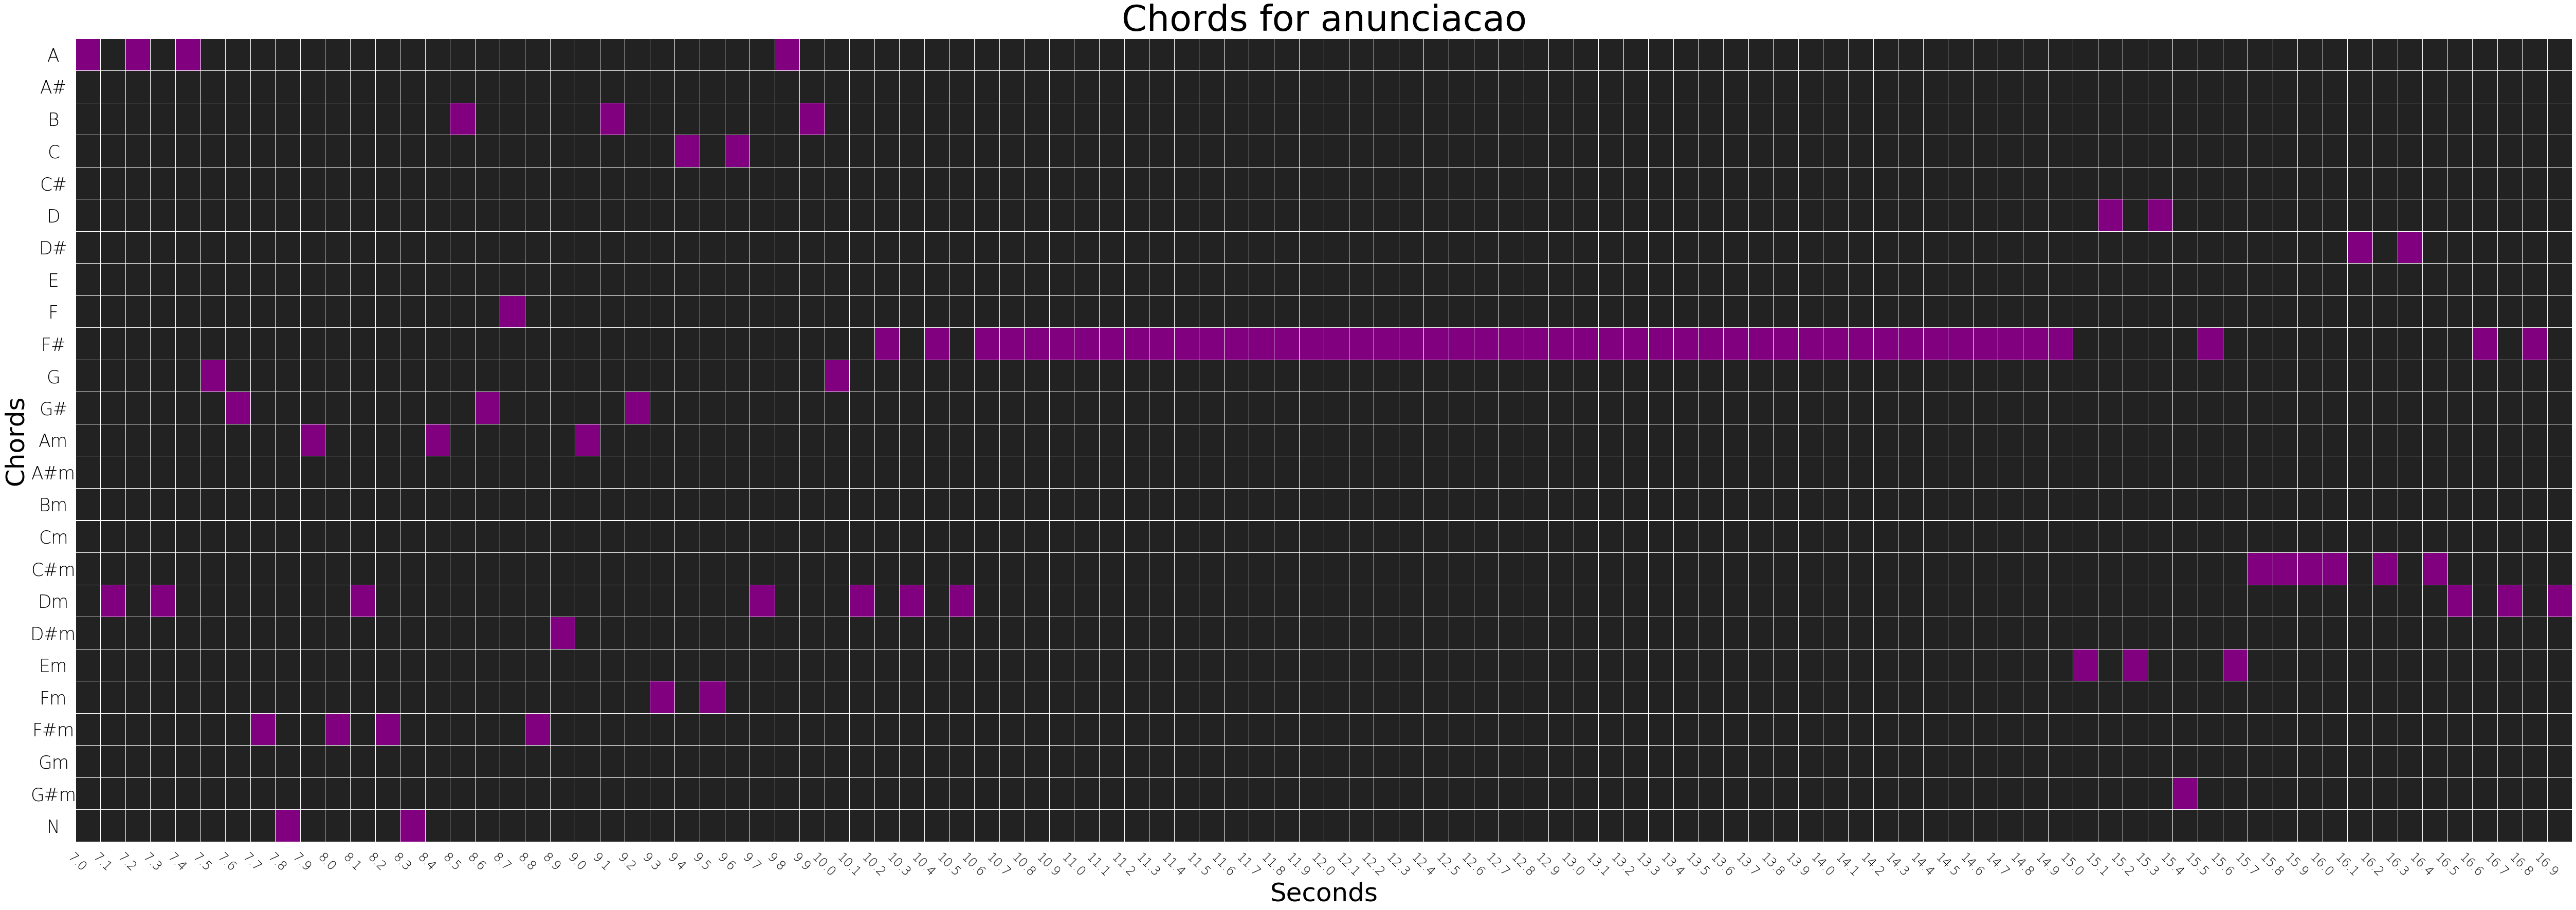

In [43]:
DC.visualize(7, 17)

In [44]:
import numpy as np

In [45]:
keys = np.array(list(DC.chords.keys()))

In [46]:
keys

array(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#',
       'Am', 'A#m', 'Bm', 'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m',
       'Gm', 'G#m', 'N'], dtype='<U3')

In [48]:
list_chords = []
for i in DC.one_hot_preds[:, :].T:
    list_chords.append(keys[np.argmax(i)])


In [49]:
from transformers import BertTokenizer, AutoModelForSequenceClassification

# Caminho para a pasta onde você salvou o modelo e o tokenizer
model_path = "./lr0.0001wd0.01/"

# Carregar o tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

# Carregar o modelo
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [50]:
import torch
import numpy as np

In [87]:
feels = {
    "0": "happy",
    "1": "sad",
    "2": "relaxing",
    "3": "angry",
    "4": "neutral"
}
feels_inverted = {v: k for k, v in feels.items()}

In [60]:
phrase = ''
feels_result = []
for idx, chord in enumerate(list_chords):
    phrase += chord + ' '
    if(idx % 20 == 0 or idx == len(list_chords)-1):
        # 1. Tokenizar a entrada

        tokens = tokenizer.encode_plus(phrase, return_tensors="pt")
        encoding = {k: v.to(model.device) for k,v in tokens.items()}
        # 2. Fazer a previsão 
        with torch.no_grad():
            outputs = model(**encoding)

        # O output é uma tupla onde o primeiro item é a saída do modelo.
        # O tamanho do output será [1, número de tokens, tamanho do embedding]
        predicted = outputs

        logits = outputs.logits
        feelin_index = np.argmax(logits)
        feels_result.append(feels[str(feelin_index.item())])
        phrase = ''
        

In [61]:
from collections import Counter
counter = Counter(feels_result)

palavra_mais_comum = counter.most_common(1)[0][0]

print(palavra_mais_comum)

happy


In [86]:
feels

{'0': 'happy', '1': 'sad', '2': 'relaxing', '3': 'angry', '4': 'neutral'}

In [101]:
def one_hot(class_ids, num_classes):
    class_ids = class_ids.astype('int32')
    oh = np.zeros((len(class_ids), num_classes), dtype=np.int32)
    oh[np.arange(len(class_ids)), class_ids] = 1

    assert (oh.argmax(axis=1) == class_ids).all()
    assert (oh.sum(axis=1) == 1).all()

    return oh

final_preds = np.array([int(feels_inverted[i]) for i in feels_result])
one_hot_preds = one_hot(final_preds, len(feels))

one_hot_preds = one_hot_preds.transpose()

In [103]:
one_hot_preds.shape

(5, 146)

In [108]:
one_hot_preds.shape

(5, 146)

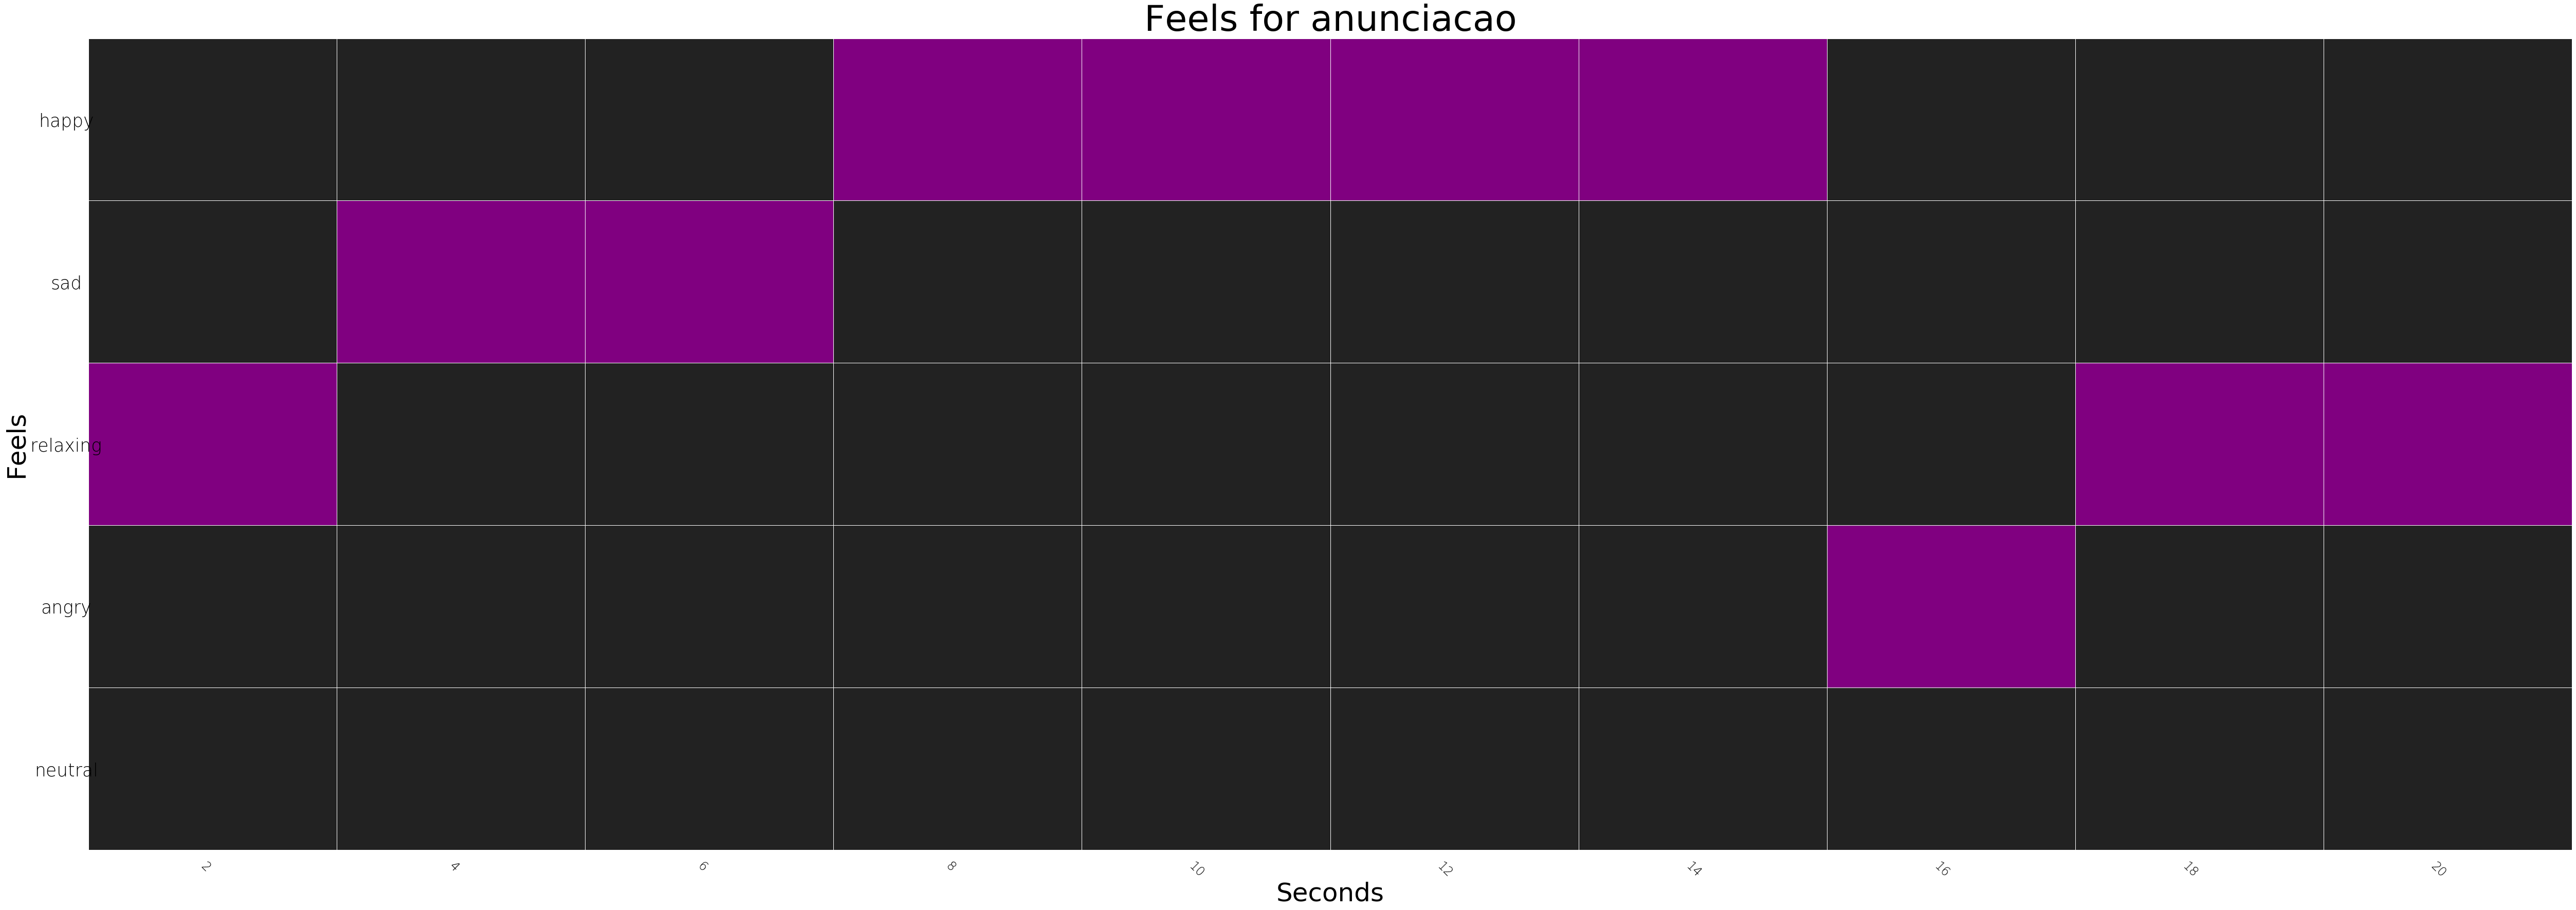

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
def visualize_feels(song_name, one_hot_preds, start, end):
    
    cmap = sns.dark_palette('purple', as_cmap=True)
    chart = sns.heatmap(one_hot_preds[:,start:end], cmap=cmap, xticklabels=np.arange(2, end*2+2, 2), yticklabels=np.array(list(feels.values())), linewidths=.03, cbar=False)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=-45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large',
        )

    chart.set_yticklabels(
        chart.get_yticklabels(), 
        rotation=0,
        horizontalalignment='center',
        fontweight='light',
        fontsize='xx-large',
        )

    chart.set_title(f'Feels for {song_name}', fontsize=70)
    chart.set_ylabel('Feels', fontsize=50)
    chart.set_xlabel('Seconds', fontsize=50)

    plt.tight_layout()
    plt.show()
visualize_feels(DC.song_name, one_hot_preds, 0, 10)
